In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, to_dense_adj, convert
from torch_geometric.data import DataLoader, DenseDataLoader
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.nn import global_mean_pool, GlobalAttention

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *

set_rc_params()

np.random.seed(42)
torch.manual_seed(42)

In [2]:
k = 10

path = "output/mutag/"
path_tsne = os.path.join(path, "TSNE")
path_pca = os.path.join(path, "PCA")
path_kmeans = os.path.join(path, f"{k}_KMeans")
path_hc = os.path.join(path, f"HC")
os.makedirs(path, exist_ok=True)
os.makedirs(path_tsne, exist_ok=True)
os.makedirs(path_pca, exist_ok=True)
os.makedirs(path_kmeans, exist_ok=True)
os.makedirs(path_hc, exist_ok=True)

batch_size = 20
graphs = load_real_data("Mutagenicity")
train_loader, test_loader, full_loader = prepare_real_data(graphs, 0.8, batch_size)
labels = next(iter(full_loader)).y

model = Mutag_GCN(graphs.num_node_features, graphs.num_classes)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 14], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True

Class split - Training 0: 1913 1:1556, Test 0: 488 1: 380


Epoch: 000, Train Loss: 0.63605, Test Loss: 0.58555, Train Acc: 0.70395, Test Acc: 0.68433
Epoch: 001, Train Loss: 0.57067, Test Loss: 0.55539, Train Acc: 0.72528, Test Acc: 0.72696
Epoch: 002, Train Loss: 0.55945, Test Loss: 0.54423, Train Acc: 0.72989, Test Acc: 0.73618
Epoch: 003, Train Loss: 0.54774, Test Loss: 0.53260, Train Acc: 0.74950, Test Acc: 0.73502
Epoch: 004, Train Loss: 0.54689, Test Loss: 0.55486, Train Acc: 0.73105, Test Acc: 0.71313
Epoch: 005, Train Loss: 0.54339, Test Loss: 0.55508, Train Acc: 0.71000, Test Acc: 0.72350
Epoch: 006, Train Loss: 0.52784, Test Loss: 0.52113, Train Acc: 0.75555, Test Acc: 0.74194
Epoch: 007, Train Loss: 0.52393, Test Loss: 0.52813, Train Acc: 0.75930, Test Acc: 0.75922
Epoch: 008, Train Loss: 0.51757, Test Loss: 0.51165, Train Acc: 0.75757, Test Acc: 0.75922
Epoch: 009, Train Loss: 0.52494, Test Loss: 0.50324, Train Acc: 0.76477, Test Acc: 0.75346
Epoch: 010, Train Loss: 0.51793, Test Loss: 0.50150, Train Acc: 0.77054, Test Acc: 0.77074

Epoch: 091, Train Loss: 0.40030, Test Loss: 0.49449, Train Acc: 0.81349, Test Acc: 0.78571
Epoch: 092, Train Loss: 0.41219, Test Loss: 0.46809, Train Acc: 0.82733, Test Acc: 0.79954
Epoch: 093, Train Loss: 0.40395, Test Loss: 0.47005, Train Acc: 0.83108, Test Acc: 0.80530
Epoch: 094, Train Loss: 0.40319, Test Loss: 0.44878, Train Acc: 0.83453, Test Acc: 0.79954
Epoch: 095, Train Loss: 0.39721, Test Loss: 0.46120, Train Acc: 0.82646, Test Acc: 0.81452
Epoch: 096, Train Loss: 0.39904, Test Loss: 0.44478, Train Acc: 0.83943, Test Acc: 0.80069
Epoch: 097, Train Loss: 0.39993, Test Loss: 0.49107, Train Acc: 0.83482, Test Acc: 0.81912
Epoch: 098, Train Loss: 0.39908, Test Loss: 0.45465, Train Acc: 0.82819, Test Acc: 0.80300
Epoch: 099, Train Loss: 0.39865, Test Loss: 0.45344, Train Acc: 0.82762, Test Acc: 0.80991
Epoch: 100, Train Loss: 0.39715, Test Loss: 0.43583, Train Acc: 0.83425, Test Acc: 0.80991
Epoch: 101, Train Loss: 0.39675, Test Loss: 0.43819, Train Acc: 0.84059, Test Acc: 0.82719

Epoch: 182, Train Loss: 0.36417, Test Loss: 0.47052, Train Acc: 0.85385, Test Acc: 0.80991
Epoch: 183, Train Loss: 0.35957, Test Loss: 0.46356, Train Acc: 0.85846, Test Acc: 0.81106
Epoch: 184, Train Loss: 0.35930, Test Loss: 0.48956, Train Acc: 0.85961, Test Acc: 0.81682
Epoch: 185, Train Loss: 0.36725, Test Loss: 0.49141, Train Acc: 0.85558, Test Acc: 0.82143
Epoch: 186, Train Loss: 0.36284, Test Loss: 0.49411, Train Acc: 0.85471, Test Acc: 0.80991
Epoch: 187, Train Loss: 0.34871, Test Loss: 0.49656, Train Acc: 0.86019, Test Acc: 0.80415
Epoch: 188, Train Loss: 0.35458, Test Loss: 0.46863, Train Acc: 0.85731, Test Acc: 0.81221
Epoch: 189, Train Loss: 0.35247, Test Loss: 0.50050, Train Acc: 0.85356, Test Acc: 0.81567
Epoch: 190, Train Loss: 0.36001, Test Loss: 0.45383, Train Acc: 0.86307, Test Acc: 0.82143
Epoch: 191, Train Loss: 0.35195, Test Loss: 0.47814, Train Acc: 0.85356, Test Acc: 0.82373
Epoch: 192, Train Loss: 0.36628, Test Loss: 0.48093, Train Acc: 0.85270, Test Acc: 0.81106

Epoch: 273, Train Loss: 0.33456, Test Loss: 0.50638, Train Acc: 0.86740, Test Acc: 0.81797
Epoch: 274, Train Loss: 0.33949, Test Loss: 0.48880, Train Acc: 0.86480, Test Acc: 0.82143
Epoch: 275, Train Loss: 0.33016, Test Loss: 0.48967, Train Acc: 0.86106, Test Acc: 0.81106
Epoch: 276, Train Loss: 0.33884, Test Loss: 0.49295, Train Acc: 0.86365, Test Acc: 0.81106
Epoch: 277, Train Loss: 0.32835, Test Loss: 0.49571, Train Acc: 0.86913, Test Acc: 0.81682
Epoch: 278, Train Loss: 0.32887, Test Loss: 0.48953, Train Acc: 0.87143, Test Acc: 0.81797
Epoch: 279, Train Loss: 0.32595, Test Loss: 0.50949, Train Acc: 0.86711, Test Acc: 0.81452
Epoch: 280, Train Loss: 0.32855, Test Loss: 0.48357, Train Acc: 0.86538, Test Acc: 0.81567
Epoch: 281, Train Loss: 0.32991, Test Loss: 0.50035, Train Acc: 0.86941, Test Acc: 0.81106
Epoch: 282, Train Loss: 0.32907, Test Loss: 0.50229, Train Acc: 0.85875, Test Acc: 0.81221
Epoch: 283, Train Loss: 0.33019, Test Loss: 0.51926, Train Acc: 0.86653, Test Acc: 0.80530

Epoch: 364, Train Loss: 0.31256, Test Loss: 0.53490, Train Acc: 0.87835, Test Acc: 0.81797
Epoch: 365, Train Loss: 0.31971, Test Loss: 0.50360, Train Acc: 0.87806, Test Acc: 0.82143
Epoch: 366, Train Loss: 0.30530, Test Loss: 0.54929, Train Acc: 0.87172, Test Acc: 0.81336
Epoch: 367, Train Loss: 0.31851, Test Loss: 0.52046, Train Acc: 0.87835, Test Acc: 0.81336
Epoch: 368, Train Loss: 0.31214, Test Loss: 0.56016, Train Acc: 0.86884, Test Acc: 0.80645
Epoch: 369, Train Loss: 0.32026, Test Loss: 0.50216, Train Acc: 0.88037, Test Acc: 0.81221
Epoch: 370, Train Loss: 0.31056, Test Loss: 0.51112, Train Acc: 0.87604, Test Acc: 0.82028
Epoch: 371, Train Loss: 0.30860, Test Loss: 0.55892, Train Acc: 0.87950, Test Acc: 0.82604
Epoch: 372, Train Loss: 0.31710, Test Loss: 0.50976, Train Acc: 0.87460, Test Acc: 0.81682
Epoch: 373, Train Loss: 0.31417, Test Loss: 0.50056, Train Acc: 0.88037, Test Acc: 0.82258
Epoch: 374, Train Loss: 0.30976, Test Loss: 0.54882, Train Acc: 0.87547, Test Acc: 0.81912

Epoch: 455, Train Loss: 0.29630, Test Loss: 0.52783, Train Acc: 0.88469, Test Acc: 0.82604
Epoch: 456, Train Loss: 0.29788, Test Loss: 0.60104, Train Acc: 0.86740, Test Acc: 0.80415
Epoch: 457, Train Loss: 0.29536, Test Loss: 0.56752, Train Acc: 0.88181, Test Acc: 0.81567
Epoch: 458, Train Loss: 0.30745, Test Loss: 0.56131, Train Acc: 0.88239, Test Acc: 0.81336
Epoch: 459, Train Loss: 0.29274, Test Loss: 0.54167, Train Acc: 0.88440, Test Acc: 0.82719
Epoch: 460, Train Loss: 0.29779, Test Loss: 0.54718, Train Acc: 0.87749, Test Acc: 0.80069
Epoch: 461, Train Loss: 0.29496, Test Loss: 0.52254, Train Acc: 0.88325, Test Acc: 0.82143
Epoch: 462, Train Loss: 0.29154, Test Loss: 0.55765, Train Acc: 0.88095, Test Acc: 0.81682
Epoch: 463, Train Loss: 0.29312, Test Loss: 0.52303, Train Acc: 0.88873, Test Acc: 0.81682
Epoch: 464, Train Loss: 0.30186, Test Loss: 0.57196, Train Acc: 0.87028, Test Acc: 0.80876
Epoch: 465, Train Loss: 0.30744, Test Loss: 0.54609, Train Acc: 0.88498, Test Acc: 0.81797

Epoch: 546, Train Loss: 0.28367, Test Loss: 0.54684, Train Acc: 0.87893, Test Acc: 0.82028
Epoch: 547, Train Loss: 0.29031, Test Loss: 0.53732, Train Acc: 0.88354, Test Acc: 0.81682
Epoch: 548, Train Loss: 0.29587, Test Loss: 0.53048, Train Acc: 0.88354, Test Acc: 0.82143
Epoch: 549, Train Loss: 0.27949, Test Loss: 0.55490, Train Acc: 0.89161, Test Acc: 0.81336
Epoch: 550, Train Loss: 0.27659, Test Loss: 0.57652, Train Acc: 0.88844, Test Acc: 0.81682
Epoch: 551, Train Loss: 0.28664, Test Loss: 0.58103, Train Acc: 0.88296, Test Acc: 0.81682
Epoch: 552, Train Loss: 0.28389, Test Loss: 0.57880, Train Acc: 0.88498, Test Acc: 0.81452
Epoch: 553, Train Loss: 0.28492, Test Loss: 0.54189, Train Acc: 0.88902, Test Acc: 0.81682
Epoch: 554, Train Loss: 0.27958, Test Loss: 0.56915, Train Acc: 0.89161, Test Acc: 0.82488
Epoch: 555, Train Loss: 0.27615, Test Loss: 0.58346, Train Acc: 0.88729, Test Acc: 0.80184
Epoch: 556, Train Loss: 0.28611, Test Loss: 0.58630, Train Acc: 0.88815, Test Acc: 0.81221

Epoch: 637, Train Loss: 0.27275, Test Loss: 0.59222, Train Acc: 0.89305, Test Acc: 0.82028
Epoch: 638, Train Loss: 0.28051, Test Loss: 0.61836, Train Acc: 0.89276, Test Acc: 0.82719
Epoch: 639, Train Loss: 0.27189, Test Loss: 0.58845, Train Acc: 0.88988, Test Acc: 0.82143
Epoch: 640, Train Loss: 0.27657, Test Loss: 0.65191, Train Acc: 0.89421, Test Acc: 0.81567
Epoch: 641, Train Loss: 0.28884, Test Loss: 0.56462, Train Acc: 0.87230, Test Acc: 0.80876
Epoch: 642, Train Loss: 0.26981, Test Loss: 0.59295, Train Acc: 0.88815, Test Acc: 0.81452
Epoch: 643, Train Loss: 0.26339, Test Loss: 0.61354, Train Acc: 0.89219, Test Acc: 0.82719
Epoch: 644, Train Loss: 0.28127, Test Loss: 0.58343, Train Acc: 0.89363, Test Acc: 0.81221
Epoch: 645, Train Loss: 0.27662, Test Loss: 0.56880, Train Acc: 0.88815, Test Acc: 0.82719
Epoch: 646, Train Loss: 0.27186, Test Loss: 0.53768, Train Acc: 0.89075, Test Acc: 0.82488
Epoch: 647, Train Loss: 0.26928, Test Loss: 0.60215, Train Acc: 0.89190, Test Acc: 0.81336

Epoch: 728, Train Loss: 0.26324, Test Loss: 0.59938, Train Acc: 0.89190, Test Acc: 0.81797
Epoch: 729, Train Loss: 0.26445, Test Loss: 0.58269, Train Acc: 0.89939, Test Acc: 0.81797
Epoch: 730, Train Loss: 0.27120, Test Loss: 0.61248, Train Acc: 0.90199, Test Acc: 0.82258
Epoch: 731, Train Loss: 0.27169, Test Loss: 0.59538, Train Acc: 0.90285, Test Acc: 0.81912
Epoch: 732, Train Loss: 0.26471, Test Loss: 0.57792, Train Acc: 0.90170, Test Acc: 0.80991
Epoch: 733, Train Loss: 0.27581, Test Loss: 0.56353, Train Acc: 0.89421, Test Acc: 0.81567
Epoch: 734, Train Loss: 0.26556, Test Loss: 0.62583, Train Acc: 0.88786, Test Acc: 0.81221
Epoch: 735, Train Loss: 0.27586, Test Loss: 0.58193, Train Acc: 0.89824, Test Acc: 0.81106
Epoch: 736, Train Loss: 0.25824, Test Loss: 0.60281, Train Acc: 0.89536, Test Acc: 0.81567
Epoch: 737, Train Loss: 0.26367, Test Loss: 0.61233, Train Acc: 0.89334, Test Acc: 0.81567
Epoch: 738, Train Loss: 0.25766, Test Loss: 0.56355, Train Acc: 0.90516, Test Acc: 0.81797

Epoch: 819, Train Loss: 0.25191, Test Loss: 0.66477, Train Acc: 0.89738, Test Acc: 0.81221
Epoch: 820, Train Loss: 0.25021, Test Loss: 0.59350, Train Acc: 0.90862, Test Acc: 0.81797
Epoch: 821, Train Loss: 0.25850, Test Loss: 0.57579, Train Acc: 0.89911, Test Acc: 0.81336
Epoch: 822, Train Loss: 0.24998, Test Loss: 0.58855, Train Acc: 0.90112, Test Acc: 0.81912
Epoch: 823, Train Loss: 0.25968, Test Loss: 0.63923, Train Acc: 0.90199, Test Acc: 0.82143
Epoch: 824, Train Loss: 0.25632, Test Loss: 0.62623, Train Acc: 0.90026, Test Acc: 0.81336
Epoch: 825, Train Loss: 0.24884, Test Loss: 0.62076, Train Acc: 0.89767, Test Acc: 0.80991
Epoch: 826, Train Loss: 0.24997, Test Loss: 0.59027, Train Acc: 0.90631, Test Acc: 0.82488
Epoch: 827, Train Loss: 0.25924, Test Loss: 0.62962, Train Acc: 0.90516, Test Acc: 0.81106
Epoch: 828, Train Loss: 0.25557, Test Loss: 0.61367, Train Acc: 0.90199, Test Acc: 0.81797
Epoch: 829, Train Loss: 0.25892, Test Loss: 0.62653, Train Acc: 0.89651, Test Acc: 0.82028

Epoch: 910, Train Loss: 0.24724, Test Loss: 0.69975, Train Acc: 0.89132, Test Acc: 0.80530
Epoch: 911, Train Loss: 0.24864, Test Loss: 0.65587, Train Acc: 0.90343, Test Acc: 0.81682
Epoch: 912, Train Loss: 0.24020, Test Loss: 0.66805, Train Acc: 0.90775, Test Acc: 0.81912
Epoch: 913, Train Loss: 0.24425, Test Loss: 0.68511, Train Acc: 0.90257, Test Acc: 0.80184
Epoch: 914, Train Loss: 0.25208, Test Loss: 0.67603, Train Acc: 0.90631, Test Acc: 0.81221
Epoch: 915, Train Loss: 0.24820, Test Loss: 0.70572, Train Acc: 0.89334, Test Acc: 0.82028
Epoch: 916, Train Loss: 0.24128, Test Loss: 0.62874, Train Acc: 0.90314, Test Acc: 0.81797
Epoch: 917, Train Loss: 0.24990, Test Loss: 0.68598, Train Acc: 0.91438, Test Acc: 0.81682
Epoch: 918, Train Loss: 0.24131, Test Loss: 0.66361, Train Acc: 0.90920, Test Acc: 0.82258
Epoch: 919, Train Loss: 0.24813, Test Loss: 0.65854, Train Acc: 0.90833, Test Acc: 0.81912
Epoch: 920, Train Loss: 0.24790, Test Loss: 0.69592, Train Acc: 0.90891, Test Acc: 0.81452

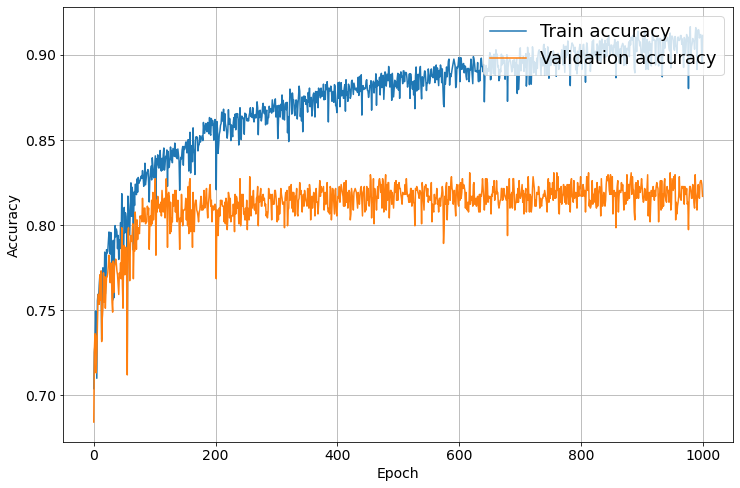

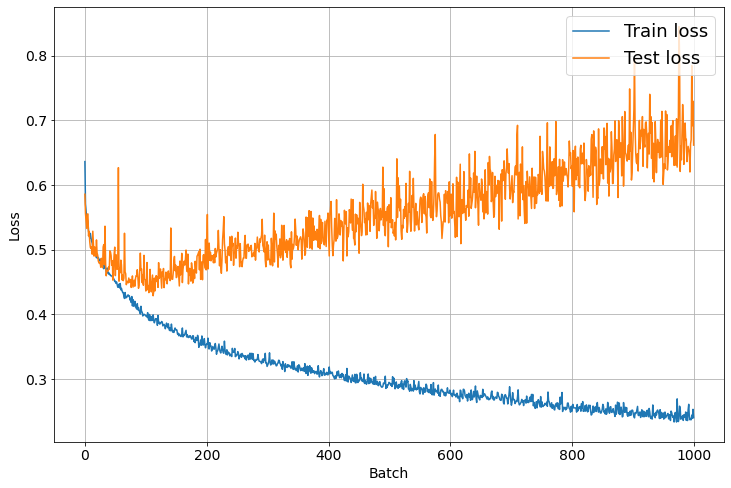

In [3]:
load_pretrained = False

if load_pretrained:
    model.load_state_dict(torch.load("models/mutagenicity_model.pkl"))
    model.eval()

    with open("models/mutagenicity_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())

else:
#     model.apply(weights_init)
    train_graph_class(model, train_loader, test_loader, full_loader, 1000, 0.005, path)

# TSNE

In [ ]:
# TSNE conversion
tsne_models = []
tsne_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "TSNE-Reduced", key, path_tsne, "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

# PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA-Reduced", layer_num, path_pca, "(coloured by labels)")
    
    pca_models.append(pca_model)
    pca_data.append(d)

# Perform KMeans Clustering

In [ ]:
num_nodes_view = 5
num_expansions = 2

dataset_data = next(iter(full_loader))
edges = dataset_data.edge_index.transpose(0, 1).detach().numpy()
y = dataset_data.y

raw_sample_graphs = []
raw_sample_feat = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "KMeans", k, key, path_kmeans, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "KMeans", k, key, path_kmeans, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, y, key, k, "KMeans-Raw", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

In [ ]:
tsne_sample_graphs = []
tsne_sample_feat = []
tsne_kmeans_models = []
for layer_num, (key, item) in enumerate(zip(activation_list, tsne_data)):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, key, path_kmeans, "TSNE")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, y, key, k, "KMeans-TSNE", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    
pca_sample_graphs = []
pca_sample_feat = []
pca_kmeans_models = []
for key, item in zip(activation_list, pca_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)
        
    plot_clusters(item, pred_labels, "KMeans", k, key, path_kmeans, "PCA")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, y, key, k, "KMeans-PCA", num_nodes_view, edges, num_expansions, path_kmeans, dataset_data)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

In [ ]:
mutag_heuristics = Mutag_Heuristics()

for layer_num, (key, sample, feat) in enumerate(zip(activation_list, raw_sample_graphs, raw_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-Raw", path_kmeans)
    
for layer_num, (key, sample, feat) in enumerate(zip(activation_list, tsne_sample_graphs, tsne_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-TSNE", path_kmeans)
    
for layer_num, (key, sample, feat) in enumerate(zip(activation_list, pca_sample_graphs, pca_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, key, "KMeans-PCA", path_kmeans)
    

# Perform Hierarchical Clustering

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "Raw", layer_num, path_hc)

In [ ]:
raw_n_clusters = [3, 3, 18, 20]

raw_sample_graphs = []
raw_sample_feat = []
raw_hc_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(activation)
    
    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC", n, layer_num, path_hc, "Raw", "_PCA", "(PCA Reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-Raw", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    raw_sample_graphs.append(sample_graphs)
    raw_sample_feat.append(sample_feat)
    raw_hc_models.append(hc)

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "TSNE", layer_num, path_hc)

In [ ]:
tsne_n_clusters = [7, 12, 20, 20]

tsne_sample_graphs = []
tsne_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "TSNE")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-TSNE", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    tsne_sample_graphs.append(sample_graphs)
    tsne_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, path_hc)

In [ ]:
pca_n_clusters = [7, 12, 20, 20]

pca_sample_graphs = []
pca_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
    pred_labels = hc.fit_predict(item)
    
    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, path_hc, "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, y, layer_num, n, "HC-PCA", num_nodes_view, edges, num_expansions, path_hc, dataset_data)
    
    pca_sample_graphs.append(sample_graphs)
    pca_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

In [ ]:
for layer_num, (sample, feat) in enumerate(zip(raw_sample_graphs, raw_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-RAW", path_kmeans)
    
for layer_num, (sample, feat) in enumerate(zip(tsne_sample_graphs, tsne_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-TSNE", path_hc)
    
for layer_num, (sample, feat) in enumerate(zip(pca_sample_graphs, pca_sample_feat)):
    mutag_heuristics.plot_heuristics_table(sample, feat, layer_num, "HC-PCA", path_hc)

# Activation to Concept to Class

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "PCA")
    
plot_completeness_table("Kmeans", "Decision Tree", completeness_scores, path_kmeans)
    

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["Kmeans", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_kmeans, i, k, "PCA")
    
plot_completeness_table("Kmeans", "Logistic Regression", completeness_scores, path_kmeans)
    

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "Raw")
    
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")
    
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")

plot_completeness_table("HC", "Decision Tree", completeness_scores, path_hc)

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "Raw", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "Raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "TSNE-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "TSNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, graphs, dataset_data.y, edges, i, True)
    
    d = ["HC", "PCA-Reduced", str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(path_hc, i, n, "PCA")

plot_completeness_table("HC", "Logistic Regression", completeness_scores, path_hc)
    

# Graph Similarity Score

In [ ]:
graph_scores = []
view = 3
max_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)
    
    for k_idx in range(k):        
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, y, i, n, "KMeans-Raw", view, edges, num_expansions, path_hc, dataset_data)
        
        
for i, item in enumerate(tsne_data): 
    distances = get_node_distances(tsne_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_kmeans_models[i], item, dataset_data.y, i, n, "KMeans-TSNE", view, edges, num_expansions, path_hc, dataset_data)
        

        
for i, item in enumerate(pca_data):
    distances = get_node_distances(pca_kmeans_models[i], item)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["KMeans", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_kmeans_models[i], item, dataset_data.y, i, n, "KMeans-PCA", view, edges, num_expansions, path_hc, dataset_data)
        
    
plot_graph_similarity_table("HC", graph_scores, path_hc)
    

In [ ]:
graph_scores = []
view = 3
max_nodes = 15

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)
    
    for k_idx in range(n):        
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "Raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_hc_models[i], d_item, y, i, n, "HC-Raw", view, edges, num_expansions, path_hc, dataset_data)
        
        
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "TSNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_hc_models[i], d_item, y, i, n, "HC-TSNE", view, edges, num_expansions, path_hc, dataset_data)
        

        
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _ = get_top_subgraphs(top_indices, dataset_data.y, edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_nodes, view)
        print(score)
        
        d = ["HC", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_hc_models[i], d_item, y, i, n, "HC-PCA", view, edges, num_expansions, path_hc, dataset_data)
        
    
plot_graph_similarity_table("HC", graph_scores, path_hc)
    

In [ ]:
color_map = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

g1 = nx.Graph()
g1.add_edge(0, 1)
g1.add_edge(1, 2)
g1.add_edge(2, 3)
g1.add_edge(3, 4)
g1.add_edge(4, 5)
g1.add_edge(5, 6)
g1.add_edge(6, 7)
g1.add_edge(7, 8)
g1.add_edge(8, 9)
g1.add_edge(9, 10)
g1.add_edge(10, 11)
g1.add_edge(11, 12)
g1.add_edge(12, 13)

nx.draw(g1, node_color=color_map, with_labels=True)
plt.show()

# GNNExplainer

In [ ]:
# node_idx = 572

# # convert to edge format
# edges = edge_list.transpose(0, 1).t().contiguous()

# explainer = GNNExplainer2(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, node_data_x, edges)

In [ ]:
# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=node_data_y, threshold=0.8)
# plt.show()

In [ ]:
# # 1) get 3 closest nodes of a cluster
# dataset_data = next(iter(full_loader))
# edges = dataset_data.edge_index.transpose(0, 1).detach().numpy()

# def get_top_graphs(graphs, top_indices):    
#     top_graphs = []
#     color_maps = []
#     graph_labels = []
        
#     for idx in top_indices:
#         graph_data = graphs[int(idx)]
#         new_G = nx.Graph()
#         new_G.add_edges_from(graph_data.edge_index.transpose(0, 1).numpy())
#         top_graphs.append(new_G)
        
#         color_map = []
#         for node, attribute in zip(new_G, graph_data.x.numpy()):
#             color_idx = np.argmax(attribute, axis=0)
#             color_map.append(color_idx)
            
#         color_maps.append(color_map)
        
#         graph_labels.append(graph_data.y)
            
#     return top_graphs, color_maps, graph_labels


# def plot_samples(graphs, clustering_model, layer, data, clustering_type, output):
#     num_nodes_view = 5
    
#     fig, axes = plt.subplots(k, num_nodes_view, figsize=(30,30))
#     fig.suptitle(f'Nearest to {clustering_type} Centroid for Layer {layer}', fontsize=40)

#     l = list(range(0, k))

#     for i, ax_list in zip(l, axes):        
#         # get top graphs
#         distances = clustering_model.transform(data)[:, i]
#         top_indices = np.argsort(distances)[::][:num_nodes_view]
#         top_graphs, color_maps, graph_labels = get_top_graphs(graphs, top_indices)
        
#         for ax, new_G, color_map, g_label in zip(ax_list, top_graphs, color_maps, graph_labels):
#             nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)
#             ax.set_title(f"label {g_label}", fontsize=14)
            
#     plt.savefig(os.path.join(path, f"{output}.png"))
#     plt.show()

In [ ]:
# class ActivationClassifier:
#     def __init__(self, tsne_data, clustering_model, classifier_type, x, y, edge_list, layer):
#         self.tsne_data = tsne_data
#         self.clustering_model = clustering_model
#         self.classifier_type = classifier_type
#         self.x = x.detach().numpy()
#         self.y = y.detach().numpy()
#         self.edge_list = edge_list
#         self.layer = layer
        
#         self.classifier, self.accuracy = self._train_classifier()
        
        
#     def _train_classifier(self):
#         concepts = []
#         for node_idx in range(len(node_data_x)):
#             concepts.append(self.activation_to_concept(node_idx))
          
#         if self.classifier_type == 'decision_tree':
#             classifier = tree.DecisionTreeClassifier()
#             classifier = classifier.fit(concepts, self.y)
#         elif self.classifier_type == 'linear_regression':
#             classifier = linear_model.LinearRegression()
#             classifier = classifier.fit(concepts, self.y)
        
#         # decision tree accuracy
#         accuracy = classifier.score(concepts, self.y)

#         return classifier, accuracy
    
    
#     def get_classifier_accuracy(self):
#         return self.accuracy
    

#     def _activation_to_cluster(self, node):
#         # apply tsne
#         if isinstance(self.clustering_model, KMeans):
#             activation = tsne_data[self.layer][node]
#             activation = activation.reshape((1, 2))
#             cluster = self.clustering_model.predict(activation)
            
#         elif isinstance(self.clustering_model, AgglomerativeClustering):
#             cluster = np.array([y_hc[node]])

#         return cluster

    
#     def _cluster_to_concept(self, cluster):
#         concept = cluster

#         return concept


#     def activation_to_concept(self, node):
#         # get cluster for node
#         cluster = self._activation_to_cluster(node)

#         # return cluster number as substitute of concept
#         concept = self._cluster_to_concept(cluster)

#         return concept

    
#     def concept_to_class(self, concept):
#         concept = concept.reshape(1, -1)
#         pred = self.classifier.predict(concept)

#         return pred

In [ ]:
# # get data
# # node_data_x = torch.from_numpy(features).float()
# # node_data_y = torch.from_numpy(labels)
# # edge_list = torch.from_numpy(edges).transpose(0, 1)

# temp = next(iter(full_loader))

# node_data_x = temp.x
# node_data_y = temp.y
# edge_list = temp.edge_index.transpose(0, 1)

# # vars
# chosen_layer = len(activation_list) - 1
# KmeansActivationCls = ActivationClassifier(tsne_data, kmeans_models[chosen_layer], 'decision_tree', node_data_x, node_data_y, edge_list, chosen_layer)

# print("Decision Tree Accuracy: ", KmeansActivationCls.get_decision_tree_accuracy())

# # activation to concept
# node_idx = 224
# concept = KmeansActivationCls.activation_to_concept(node_idx)
# print("Predicted concept is: ", concept)

# cls = KmeansActivationCls.concept_to_class(concept)
# print("Predicted class is: ", cls ," where real one is: ", node_data_y[node_idx])